In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

In [62]:
# load dataset
data = pd.read_csv('train.csv')
# split dataset into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)
# separate features and labels
X_train = train_data.drop(columns=['song_popularity'])
y_train = train_data['song_popularity']
X_val = val_data.drop(columns=['song_popularity'])
y_val = val_data['song_popularity']
X_test = test_data.drop(columns=['song_popularity'])
y_test = test_data['song_popularity']


# Fill missing values in features with column mean
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

In [16]:
xgb1 = xgb.XGBClassifier(eval_metric='mlogloss', max_depth=3, learning_rate=0.1, random_state=42)
xgb2 = xgb.XGBClassifier(eval_metric='mlogloss', max_depth=5, learning_rate=0.05, random_state=42)
xgb3 = xgb.XGBClassifier(eval_metric='mlogloss', max_depth=7, learning_rate=0.2, random_state=42)
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
ensemble = VotingClassifier(estimators=[('xgb1', xgb1), ('xgb2', xgb2), ('xgb3', xgb3), ('logreg', logreg), ('rf', rf_model)], voting='soft')
ensemble.fit(X_train, y_train)
# Adjust threshold for class 1
probs = ensemble.predict_proba(X_val)
threshold = 0.4  # Lower threshold to favor class 1
y_val_pred = (probs[:, 1] > threshold).astype(int)
print("Ensemble (XGBoost + Logistic Regression + RF, threshold=0.3) Validation Report:")
print(classification_report(y_val, y_val_pred))

Ensemble (XGBoost + Logistic Regression + RF, threshold=0.3) Validation Report:
              precision    recall  f1-score   support

           0       0.65      0.59      0.62      2818
           1       0.41      0.47      0.44      1682

    accuracy                           0.55      4500
   macro avg       0.53      0.53      0.53      4500
weighted avg       0.56      0.55      0.55      4500



In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X_train_torch = scaler.fit_transform(X_train)
X_val_torch = scaler.transform(X_val)
X_train_tensor = torch.tensor(X_train_torch, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_torch, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

class LargerNN(nn.Module):
    def __init__(self, input_dim):
        super(LargerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.fc5 = nn.Linear(32, 16)
        self.bn5 = nn.BatchNorm1d(16)
        self.fc6 = nn.Linear(16, 1)
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.relu(self.bn4(self.fc4(x)))
        x = torch.relu(self.bn5(self.fc5(x)))
        x = torch.sigmoid(self.fc6(x))
        return x

model = LargerNN(X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    y_val_pred_torch = val_outputs.round().int().numpy().flatten()
    nn_accuracy = accuracy_score(y_val, y_val_pred_torch)
print(f'Neural Network Accuracy: {nn_accuracy:.4f}')

Epoch 10/100, Loss: 0.6397
Epoch 20/100, Loss: 0.6226
Epoch 20/100, Loss: 0.6226
Epoch 30/100, Loss: 0.6022
Epoch 30/100, Loss: 0.6022
Epoch 40/100, Loss: 0.5759
Epoch 40/100, Loss: 0.5759
Epoch 50/100, Loss: 0.5431
Epoch 50/100, Loss: 0.5431
Epoch 60/100, Loss: 0.5055
Epoch 60/100, Loss: 0.5055
Epoch 70/100, Loss: 0.4668
Epoch 70/100, Loss: 0.4668
Epoch 80/100, Loss: 0.4293
Epoch 80/100, Loss: 0.4293
Epoch 90/100, Loss: 0.3930
Epoch 90/100, Loss: 0.3930
Epoch 100/100, Loss: 0.3586
Neural Network Accuracy: 0.5571
Epoch 100/100, Loss: 0.3586
Neural Network Accuracy: 0.5571


In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from xgboost import XGBClassifier

# Prepare data
X_train = train_data.drop(columns=['song_popularity'])
y_train = train_data['song_popularity']
X_val = val_data.drop(columns=['song_popularity'])
y_val = val_data['song_popularity']

X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())

# Train XGBoost
xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)

# Predict probabilities
y_probs = xgb.predict_proba(X_val)[:,1]

# Find best threshold for accuracy
best_acc = 0
best_thresh = 0.5
for thresh in np.linspace(0.1, 0.9, 81):  # check thresholds 0.1 ... 0.9
    y_pred = (y_probs >= thresh).astype(int)
    acc = accuracy_score(y_val, y_pred)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh

print(f"Best Threshold: {best_thresh:.2f}, Best Accuracy: {best_acc:.4f}")

# Final predictions with best threshold
y_pred = (y_probs >= best_thresh).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("ROC-AUC:", roc_auc_score(y_val, y_probs))


Best Threshold: 0.57, Best Accuracy: 0.6280
Confusion Matrix:
[[2747   71]
 [1603   79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.97      0.77      2818
           1       0.53      0.05      0.09      1682

    accuracy                           0.63      4500
   macro avg       0.58      0.51      0.43      4500
weighted avg       0.59      0.63      0.51      4500

ROC-AUC: 0.5459554216186246


In [ ]:
# 1.
#----------#
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=42))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_val)

print("==== Logistic Regression (Balanced) ====")
print("Accuracy:", accuracy_score(y_val, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_lr))
print("Classification Report:")
print(classification_report(y_val, y_pred_lr))


==== Logistic Regression (Balanced) ====
Accuracy: 0.5362222222222223
Confusion Matrix:
[[1556 1262]
 [ 825  857]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      2818
           1       0.40      0.51      0.45      1682

    accuracy                           0.54      4500
   macro avg       0.53      0.53      0.52      4500
weighted avg       0.56      0.54      0.54      4500



In [34]:
# 2.
#----------#

from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1]),
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_val)

print("\n==== LightGBM ====")
print("Accuracy:", accuracy_score(y_val, y_pred_lgbm))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_lgbm))
print("Classification Report:")
print(classification_report(y_val, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 7620, number of negative: 13380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.362857 -> initscore=-0.562985
[LightGBM] [Info] Start training from score -0.562985

==== LightGBM ====
Accuracy: 0.5422222222222223
Confusion Matrix:
[[1674 1144]
 [ 916  766]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.59      0.62      2818
           1       0.40      0.46      0.43      1682

    accuracy                           0.54      4500
   macro avg       0.52      0.52      0.52      4500
weighted avg       0.55      0.54      0.55      4500


==== LightGBM ====
Accuracy: 0.5422222222222223
Confusion Matr

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# get predicted probabilities
y_proba = lgbm.predict_proba(X_test)[:,1]

# try multiple thresholds
for thr in [0.3, 0.35, 0.4, 0.45, 0.5]:
    y_pred_thr = (y_proba >= thr).astype(int)
    print(f"\n==== Threshold: {thr} ====")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_thr))
    print("Classification Report:")
    print(classification_report(y_test, y_pred_thr, digits=3))



==== Threshold: 0.3 ====
Confusion Matrix:
[[ 264 2606]
 [  95 1535]]
Classification Report:
              precision    recall  f1-score   support

           0      0.735     0.092     0.164      2870
           1      0.371     0.942     0.532      1630

    accuracy                          0.400      4500
   macro avg      0.553     0.517     0.348      4500
weighted avg      0.603     0.400     0.297      4500


==== Threshold: 0.35 ====
Confusion Matrix:
[[ 486 2384]
 [ 205 1425]]
Classification Report:
              precision    recall  f1-score   support

           0      0.703     0.169     0.273      2870
           1      0.374     0.874     0.524      1630

    accuracy                          0.425      4500
   macro avg      0.539     0.522     0.398      4500
weighted avg      0.584     0.425     0.364      4500


==== Threshold: 0.4 ====
Confusion Matrix:
[[ 835 2035]
 [ 378 1252]]
Classification Report:
              precision    recall  f1-score   support

        

In [31]:
# 3.
#----------#

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

# Train LightGBM on balanced data
lgbm_res = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.05,
    random_state=42
)
lgbm_res.fit(X_train_res, y_train_res)

y_pred_smote = lgbm_res.predict(X_val)

print("\n==== LightGBM + SMOTE ====")
print("Accuracy:", accuracy_score(y_val, y_pred_smote))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_smote))
print("Classification Report:")
print(classification_report(y_val, y_pred_smote))


Before SMOTE: {0: 13380, 1: 7620}
After SMOTE: {0: 13380, 1: 13380}
[LightGBM] [Info] Number of positive: 13380, number of negative: 13380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3065
[LightGBM] [Info] Number of data points in the train set: 26760, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

==== LightGBM + SMOTE ====
Accuracy: 0.5922222222222222
Confusion Matrix:
[[2346  472]
 [1363  319]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.83      0.72      2818
           1       0.40      0.19      0.26      1682

    accuracy                           0.59      4500
   macro avg       0.52      0.51      0.49      4500
weighted avg       0.55      0.5

In [48]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Features to keep
features_to_keep = [f for f in X_train.columns if f not in ['audio_mode', 'audio_valence']]
X_train_lgb = X_train[features_to_keep]
X_val_lgb = X_val[features_to_keep]

# LightGBM with tuned hyperparameters
lgbm_tuned = LGBMClassifier(
    n_estimators=750,      # more trees
    learning_rate=0.1,     # smaller learning rate
    num_leaves=50,          # more leaves per tree
    max_depth=7,           # max depth
    min_child_samples=13,   # min data in leaf
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced', 
    random_state=42
)

lgbm_tuned.fit(X_train_lgb, y_train)
y_pred_lgb = lgbm_tuned.predict(X_val_lgb)

print("==== LightGBM - Tuned Hyperparameters ====")
print("Accuracy:", accuracy_score(y_val, y_pred_lgb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_lgb))
print("Classification Report:\n", classification_report(y_val, y_pred_lgb, digits=3))


[LightGBM] [Info] Number of positive: 7620, number of negative: 13380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [49]:
from sklearn.linear_model import LogisticRegression

# Use same features (without audio_mode and audio_valence)
X_train_lr = X_train[features_to_keep]
X_val_lr = X_val[features_to_keep]

lr_model = LogisticRegression(
    class_weight='balanced', 
    solver='liblinear', 
    max_iter=1000, 
    random_state=42
)
lr_model.fit(X_train_lr, y_train)
y_pred_lr = lr_model.predict(X_val_lr)

print("==== Logistic Regression - Comparison ====")
print("Accuracy:", accuracy_score(y_val, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_lr))
print("Classification Report:\n", classification_report(y_val, y_pred_lr, digits=3))


==== Logistic Regression - Comparison ====
Accuracy: 0.5211111111111111
Confusion Matrix:
 [[1484 1334]
 [ 821  861]]
Classification Report:
               precision    recall  f1-score   support

           0      0.644     0.527     0.579      2818
           1      0.392     0.512     0.444      1682

    accuracy                          0.521      4500
   macro avg      0.518     0.519     0.512      4500
weighted avg      0.550     0.521     0.529      4500



             feature  importance
2       acousticness        1398
13     audio_valence        1344
10       speechiness        1342
11             tempo        1342
0                 id        1308
5   instrumentalness        1282
7           liveness        1262
8           loudness        1227
4             energy        1226
1   song_duration_ms        1194
3       danceability        1186
6                key         590
12    time_signature         189
9         audio_mode         110


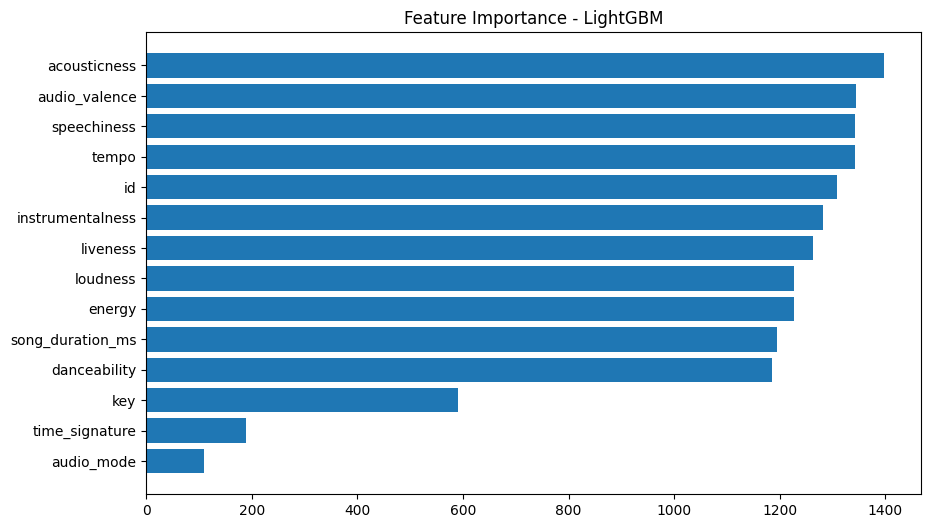

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming lgbm is your trained LightGBM model
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances)

# Optional: plot
plt.figure(figsize=(10,6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance - LightGBM")
plt.show()


In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# Keep top features only
features_to_keep = [f for f in X_train.columns if f not in ['audio_mode', 'audio_valence']]
X_train_sel = X_train[features_to_keep]
X_val_sel = X_val[features_to_keep]

# --- 1. Logistic Regression ---
lr = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42)
lr.fit(X_train_sel, y_train)
y_pred_lr = lr.predict(X_val_sel)
proba_lr = lr.predict_proba(X_val_sel)[:,1]

print("==== Logistic Regression ====")
print("Accuracy:", accuracy_score(y_val, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_lr))
print("Classification Report:\n", classification_report(y_val, y_pred_lr, digits=3))

# --- 2. LightGBM ---
lgbm = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    num_leaves=63,
    max_depth=10,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42
)
lgbm.fit(X_train_sel, y_train)
y_pred_lgbm = lgbm.predict(X_val_sel)
proba_lgbm = lgbm.predict_proba(X_val_sel)[:,1]

print("\n==== LightGBM ====")
print("Accuracy:", accuracy_score(y_val, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_lgbm))
print("Classification Report:\n", classification_report(y_val, y_pred_lgbm, digits=3))

# --- 3. XGBoost ---
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_sel, y_train)
y_pred_xgb = xgb.predict(X_val_sel)
proba_xgb = xgb.predict_proba(X_val_sel)[:,1]

print("\n==== XGBoost ====")
print("Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_xgb))
print("Classification Report:\n", classification_report(y_val, y_pred_xgb, digits=3))

# --- Ensemble: average probabilities of LR + LGBM + XGB ---
proba_ensemble = (proba_lr + proba_lgbm + proba_xgb)/3
threshold = 0.5
y_pred_ensemble = (proba_ensemble >= threshold).astype(int)

print("\n==== Ensemble (LR + LGBM + XGB) ====")
print("Accuracy:", accuracy_score(y_val, y_pred_ensemble))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_ensemble))
print("Classification Report:\n", classification_report(y_val, y_pred_ensemble, digits=3))


==== Logistic Regression ====
Accuracy: 0.5211111111111111
Confusion Matrix:
 [[1484 1334]
 [ 821  861]]
Classification Report:
               precision    recall  f1-score   support

           0      0.644     0.527     0.579      2818
           1      0.392     0.512     0.444      1682

    accuracy                          0.521      4500
   macro avg      0.518     0.519     0.512      4500
weighted avg      0.550     0.521     0.529      4500

[LightGBM] [Info] Number of positive: 7620, number of negative: 13380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive 

c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:42:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



==== XGBoost ====
Accuracy: 0.5502222222222222
Confusion Matrix:
 [[1806 1012]
 [1012  670]]
Classification Report:
               precision    recall  f1-score   support

           0      0.641     0.641     0.641      2818
           1      0.398     0.398     0.398      1682

    accuracy                          0.550      4500
   macro avg      0.520     0.520     0.520      4500
weighted avg      0.550     0.550     0.550      4500


==== Ensemble (LR + LGBM + XGB) ====
Accuracy: 0.5577777777777778
Confusion Matrix:
 [[1846  972]
 [1018  664]]
Classification Report:
               precision    recall  f1-score   support

           0      0.645     0.655     0.650      2818
           1      0.406     0.395     0.400      1682

    accuracy                          0.558      4500
   macro avg      0.525     0.525     0.525      4500
weighted avg      0.555     0.558     0.557      4500



In [69]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [106]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# -------------------------------
# 1. Read the dataset
# -------------------------------
data = pd.read_csv('train.csv')

# -------------------------------
# 2. Fill missing values for numeric columns
# -------------------------------
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

# -------------------------------
# 3. Feature Engineering
# -------------------------------

# (a) song_duration_bin: categorize duration
def duration_bin(ms):
    minutes = ms / 60000
    if minutes < 1.5:
        return 0
    elif 1.5 <= minutes < 2.5:
        return 1
    elif 2.5 <= minutes < 3.0:
        return 2
    else:
        return 3

data['song_duration_bin'] = data['song_duration_ms'].apply(duration_bin)

# (b) tempo_bin: categorize tempo
def tempo_bin(t):
    if t < 50:
        return 0
    elif 50 <= t < 100:
        return 1
    elif 100 <= t < 150:
        return 2
    elif 150 <= t < 200:
        return 3
    else:
        return 4

data['tempo_bin'] = data['tempo'].apply(tempo_bin)

# (c) energy_loudness_ratio
data['energy_loudness_ratio'] = data['energy'] / (data['loudness'] + 1e-6)  # avoid div by 0

# (d) danceability_energy
data['danceability_energy'] = data['danceability'] * data['energy']

# (e) liveness_instrumentalness
data['liveness_instrumentalness'] = data['liveness'] * data['instrumentalness']

# -------------------------------
# 4. Drop only the raw features already represented except liveness & instrumentalness
# -------------------------------
drop_cols = ['song_duration_ms', 'tempo', 'energy', 'loudness', 'danceability']
data = data.drop(columns=drop_cols)

# -------------------------------
# 5. Split data into train, val, test
# -------------------------------
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# -------------------------------
# 6. Separate features and target
# -------------------------------
target_col = 'song_popularity'

X_train = train_data.drop(columns=[target_col])
y_train = train_data[target_col]

X_val = val_data.drop(columns=[target_col])
y_val = val_data[target_col]

X_test = test_data.drop(columns=[target_col])
y_test = test_data[target_col]

print("Data preprocessing and feature engineering completed!")
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Data preprocessing and feature engineering completed!
Train shape: (21000, 14), Validation shape: (4500, 14), Test shape: (4500, 14)


In [107]:
ridge = RidgeClassifier(alpha=1.0, class_weight='balanced', random_state=42)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_val)

print("==== Ridge Classifier ====")
print("Accuracy:", accuracy_score(y_val, y_pred_ridge))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_ridge))
print("Classification Report:\n", classification_report(y_val, y_pred_ridge))


==== Ridge Classifier ====
Accuracy: 0.5306666666666666
Confusion Matrix:
 [[1502 1316]
 [ 796  886]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.53      0.59      2818
           1       0.40      0.53      0.46      1682

    accuracy                           0.53      4500
   macro avg       0.53      0.53      0.52      4500
weighted avg       0.56      0.53      0.54      4500



In [114]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -------------------------------
# 1. Keep only important features
# -------------------------------
important_features = [
    'audio_valence',
    'tempo_bin',
    'acousticness',
    'energy_loudness_ratio',
    'time_signature',
    'id',
    'speechiness',
    'danceability_energy'
]

X_train_imp = X_train[important_features]
X_val_imp = X_val[important_features]

# -------------------------------
# 2. Train GaussianNB
# -------------------------------
gnb = GaussianNB(priors=[0.5, 0.5])  # enforce equal importance for both classes
gnb.fit(X_train_imp, y_train)


# -------------------------------
# 3. Predictions & Evaluation
# -------------------------------
y_pred_val = gnb.predict(X_val_imp)

print("==== GaussianNB - Validation ====")
print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))
print("Classification Report:\n", classification_report(y_val, y_pred_val))


==== GaussianNB - Validation ====
Accuracy: 0.5473333333333333
Confusion Matrix:
 [[1806 1012]
 [1025  657]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64      2818
           1       0.39      0.39      0.39      1682

    accuracy                           0.55      4500
   macro avg       0.52      0.52      0.52      4500
weighted avg       0.55      0.55      0.55      4500



In [102]:
lgbm = LGBMClassifier(n_estimators=800, learning_rate=0.05, random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_val)
print("==== LGBM ====")
print("Accuracy:", accuracy_score(y_val, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_lgbm))
print("Classification Report:\n", classification_report(y_val, y_pred_lgbm))
xgb = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
print("==== XGBoost ====")
print("Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_xgb))
print("Classification Report:\n", classification_report(y_val, y_pred_xgb))


[LightGBM] [Info] Number of positive: 7620, number of negative: 13380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.362857 -> initscore=-0.562985
[LightGBM] [Info] Start training from score -0.562985
==== LGBM ====
Accuracy: 0.6026666666666667
Confusion Matrix:
 [[2490  328]
 [1460  222]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.88      0.74      2818
           1       0.40      0.13      0.20      1682

    accuracy                           0.60      4500
   macro avg       0.52      0.51      0.47      4500
weighted avg       0.55      0.60      0.54      4500

==

c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:21:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


==== XGBoost ====
Accuracy: 0.6111111111111112
Confusion Matrix:
 [[2540  278]
 [1472  210]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.90      0.74      2818
           1       0.43      0.12      0.19      1682

    accuracy                           0.61      4500
   macro avg       0.53      0.51      0.47      4500
weighted avg       0.56      0.61      0.54      4500



In [103]:
from sklearn.ensemble import VotingClassifier

# Voting ensemble using probabilities
ensemble = VotingClassifier(
    estimators=[
        ('gnb', GaussianNB()),
        ('lgbm', LGBMClassifier(n_estimators=800, learning_rate=0.05, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=42, use_label_encoder=False, eval_metric='logloss'))
    ],
    voting='soft'
)

# Fit on training data with feature engineering
ensemble.fit(X_train, y_train)  # Use scaled features for GaussianNB and Ridge-compatible
y_pred_ensemble = ensemble.predict(X_val)

print("==== Soft Voting Ensemble ====")
print("Accuracy:", accuracy_score(y_val, y_pred_ensemble))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_ensemble))
print("Classification Report:\n", classification_report(y_val, y_pred_ensemble))


[LightGBM] [Info] Number of positive: 7620, number of negative: 13380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.362857 -> initscore=-0.562985
[LightGBM] [Info] Start training from score -0.562985


c:\Users\Harsh\Desktop\Code\5th Sem\Data Science and AI\Kaggle Competition 1\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:21:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


==== Soft Voting Ensemble ====
Accuracy: 0.62
Confusion Matrix:
 [[2705  113]
 [1597   85]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.96      0.76      2818
           1       0.43      0.05      0.09      1682

    accuracy                           0.62      4500
   macro avg       0.53      0.51      0.43      4500
weighted avg       0.55      0.62      0.51      4500



In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# -------------------------------
# Scale features (important for QDA & SVM)
# -------------------------------
scaler = StandardScaler()

X_train = train_data.drop(columns=['song_popularity'])
y_train = train_data['song_popularity']

X_val = val_data.drop(columns=['song_popularity'])
y_val = val_data['song_popularity']

X_test = test_data.drop(columns=['song_popularity'])
y_test = test_data['song_popularity']

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# Quadratic Discriminant Analysis (QDA)
# -------------------------------
qda = QDA(store_covariance=True)
qda.fit(X_train_scaled, y_train)
y_val_pred_qda = qda.predict(X_val_scaled)

print("==== QDA - Validation ====")
print("Accuracy:", accuracy_score(y_val, y_val_pred_qda))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_qda))
print("Classification Report:\n", classification_report(y_val, y_val_pred_qda))

# -------------------------------
# Support Vector Machine (SVM, RBF kernel)
# -------------------------------
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)
y_val_pred_svm = svm.predict(X_val_scaled)

print("\n==== SVM (RBF) - Validation ====")
print("Accuracy:", accuracy_score(y_val, y_val_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_svm))
print("Classification Report:\n", classification_report(y_val, y_val_pred_svm))


==== QDA - Validation ====
Accuracy: 0.6102222222222222
Confusion Matrix:
 [[2508  310]
 [1444  238]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.89      0.74      2818
           1       0.43      0.14      0.21      1682

    accuracy                           0.61      4500
   macro avg       0.53      0.52      0.48      4500
weighted avg       0.56      0.61      0.54      4500

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.89      0.74      2818
           1       0.43      0.14      0.21      1682

    accuracy                           0.61      4500
   macro avg       0.53      0.52      0.48      4500
weighted avg       0.56      0.61      0.54      4500


==== SVM (RBF) - Validation ====
Accuracy: 0.6257777777777778
Confusion Matrix:
 [[2815    3]
 [1681    1]]
Classification Report:
               precision    recall  f1-score   support

        

In [117]:
# -------------------------------
# 7. Modeling with Balancing
# -------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- Logistic Regression (class weight balanced) ---
lr_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(class_weight="balanced", random_state=42, max_iter=500))
])

# --- SVM (class weight balanced) ---
svm_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(class_weight="balanced", random_state=42))
])

# --- KNN (with undersampling of majority class) ---
knn_pipeline = ImbPipeline(steps=[
    ("undersample", RandomUnderSampler(sampling_strategy="auto", random_state=42)),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

pipelines = {
    "Logistic Regression": lr_pipeline,
    "SVM (RBF)": svm_pipeline,
    "KNN (undersampled)": knn_pipeline
}

# -------------------------------
# 8. Training & Validation Evaluation
# -------------------------------
for name, pipe in pipelines.items():
    print(f"\n==== {name} - Validation ====")
    pipe.fit(X_train, y_train)
    y_val_pred = pipe.predict(X_val)

    acc = accuracy_score(y_val, y_val_pred)
    cm = confusion_matrix(y_val, y_val_pred)
    report = classification_report(y_val, y_val_pred)

    print(f"Accuracy: {acc}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)



==== Logistic Regression - Validation ====
Accuracy: 0.5306666666666666
Confusion Matrix:
 [[1500 1318]
 [ 794  888]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.53      0.59      2818
           1       0.40      0.53      0.46      1682

    accuracy                           0.53      4500
   macro avg       0.53      0.53      0.52      4500
weighted avg       0.56      0.53      0.54      4500


==== SVM (RBF) - Validation ====
Accuracy: 0.5306666666666666
Confusion Matrix:
 [[1500 1318]
 [ 794  888]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.53      0.59      2818
           1       0.40      0.53      0.46      1682

    accuracy                           0.53      4500
   macro avg       0.53      0.53      0.52      4500
weighted avg       0.56      0.53      0.54      4500


==== SVM (RBF) - Validation ====
Accuracy: 0.5355555555555556
Confusi

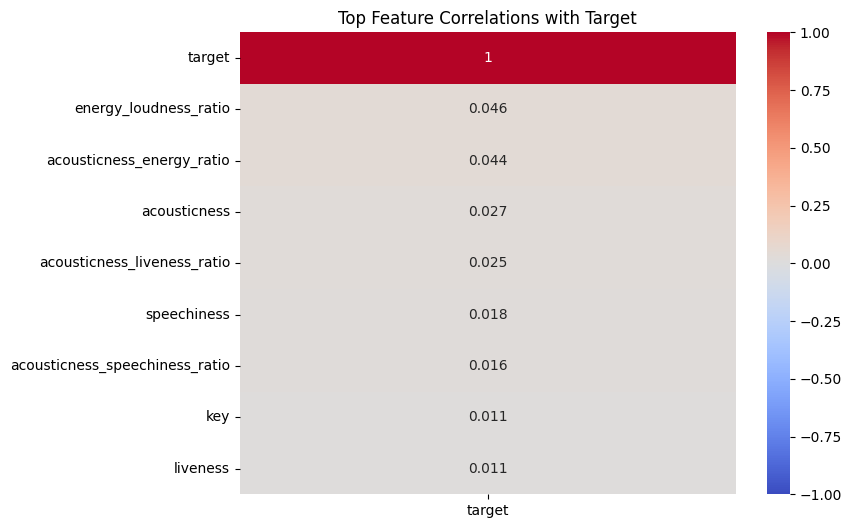

C:\Users\Harsh\AppData\Local\Temp\ipykernel_23440\2599434823.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x="importance", y="feature", palette="viridis")


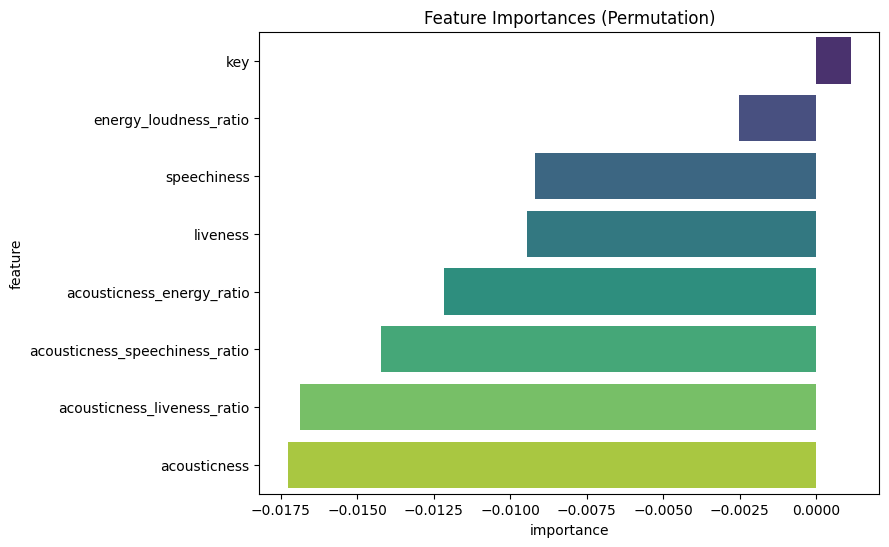

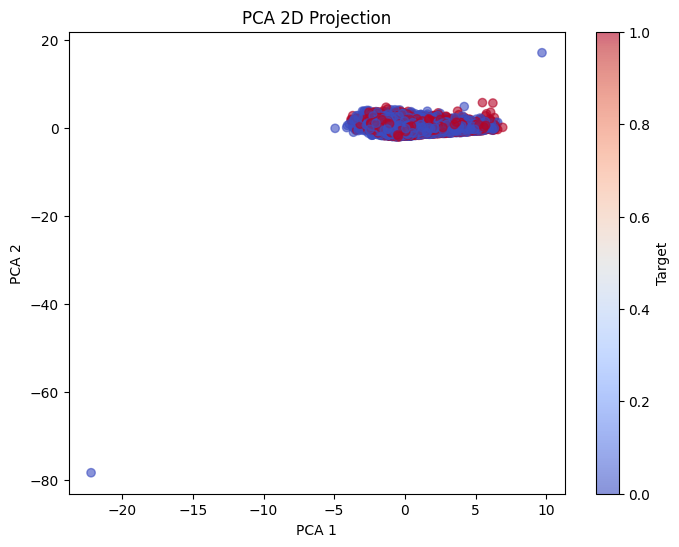

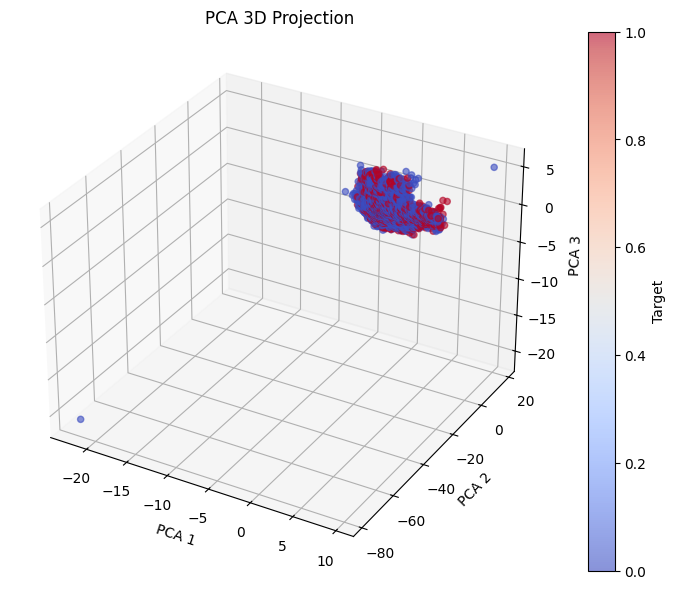

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# -------------------------------
# 1. Read the dataset
# -------------------------------
data = pd.read_csv("train.csv")

# Drop identifier columns if present
drop_cols = [c for c in ["id", "track_id", "song_id"] if c in data.columns]
data = data.drop(columns=drop_cols)

# Fill missing numeric values
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

# -------------------------------
# 2. Feature Engineering
# -------------------------------
# Keep only top features from correlation until liveness
top_features = [
    "energy_loudness_ratio", "acousticness_energy_ratio", "acousticness",
    "acousticness_liveness_ratio", "speechiness", "acousticness_speechiness_ratio",
    "key", "liveness"
]

# Generate ratio features if not already present
if "energy_loudness_ratio" not in data.columns:
    data["energy_loudness_ratio"] = data["energy"] / (data["loudness"] + 1e-6)

if "acousticness_energy_ratio" not in data.columns:
    data["acousticness_energy_ratio"] = data["acousticness"] / (data["energy"] + 1e-6)

if "acousticness_liveness_ratio" not in data.columns:
    data["acousticness_liveness_ratio"] = data["acousticness"] / (data["liveness"] + 1e-6)

if "acousticness_speechiness_ratio" not in data.columns:
    data["acousticness_speechiness_ratio"] = data["acousticness"] / (data["speechiness"] + 1e-6)

# -------------------------------
# 3. Drop raw features not needed
# -------------------------------
drop_cols = ["song_duration_ms", "tempo", "energy", "loudness", "danceability", 
             "instrumentalness"]  # keep only top_features
data = data.drop(columns=[c for c in drop_cols if c in data.columns])

# -------------------------------
# 4. Split into train/test
# -------------------------------
target_col = "song_popularity"
X = data[top_features]
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -------------------------------
# 5. Correlation heatmap
# -------------------------------
df_corr = pd.concat([X_train, y_train.rename("target")], axis=1)
corr = df_corr.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr[["target"]].sort_values(by="target", ascending=False),
            annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Top Feature Correlations with Target")
plt.show()

# -------------------------------
# 6. Permutation Importance (Random Forest)
# -------------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": result.importances_mean
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=importances, x="importance", y="feature", palette="viridis")
plt.title("Feature Importances (Permutation)")
plt.show()

# -------------------------------
# 7. PCA Visualization
# -------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pd.concat([X_train, X_test], axis=0))
y_all = pd.concat([y_train, y_test], axis=0)

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 2D PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_all, cmap="coolwarm", alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA 2D Projection")
plt.colorbar(label="Target")
plt.show()

# 3D PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
               c=y_all, cmap="coolwarm", alpha=0.6)
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("PCA 3D Projection")
fig.colorbar(p, label="Target")
plt.show()
